# CS 6140 Machine Learning: Assignment - 2 (Total Points: 100)
## Prof. Ahmad Uzair





## Question 1 - Support Vector Machine and MLP  (30 points)



 In this problem you will be applying Support Vector Machine and Multi layer perceptron for binary classification.



You will train and test Support Vector Machine (SVM) and Multi-layer Perceptron (MLP) classifiers that aim for minimum probability of classification error. You may use any standard library of your choice. The SVM should use a Gaussian (radial-basis) kernel. The MLP should be a single-hidden layer model with your choice of activation functions for all perceptrons.

Generate 1000 independent and identically distributed (iid) samples for training and 5000 iid samples for testing. All data for class L ∈ {0, 1}, which are equiprobable and two dimensional, should be generated as follows:


x = r<sub>L</sub> * [cos(θ) sin(θ)]<sup>T</sup> + n

where,

 θ ∼ Uniform[−π, π],

 n ∼ N(0, σ<sup>2</sup>I), Note: N represents the Gaussian distribution 

 r<sub>0</sub> = 2, r<sub>1</sub> = 4, σ = 1


Note: The two class sample sets will be highly overlapping two concentric disks, and due to angular symmetry, we anticipate the best classification boundary to be a circle between the two disks. Your SVM and MLP models will try to approximate it.

Use the training data with 10-fold cross-validation to determine the best hyperparameters (box constraints parameter and Gaussian kernel width for the SVM, number of perceptrons in the hidden layer for the MLP). Once these hyperparameters are set, train your final SVM and MLP classifier using the entire training data set. Apply your trained SVM and MLP classifiers to the test data set and estimate the probability of error from this data set.

Show the following: 

(1) visual and numerical demonstrations of the K-fold cross-validation process indicating how the hyperparameters for SVM and MLP classifiers are set.

(2) visual and numerical demonstrations of the performance of your SVM and MLP classifiers on the test dataset.


Hint: For hyperparameter selection, you may show the performance estimates for various choices and indicate where the best result is achieved. For test performance, you may show the data and classification boundary superimposed, along with an estimated probability of error from the samples.


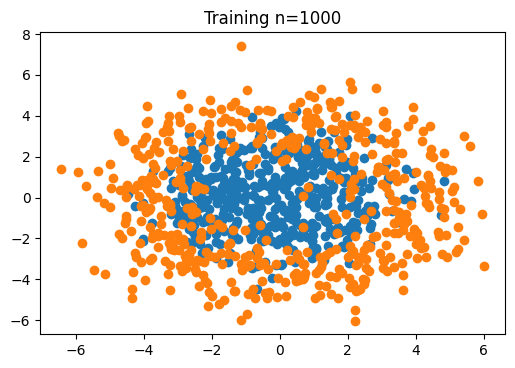

In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n = 2 #dimensionality
Ntrain = 1000
Ntest = 5000
ClassPriors = [0.5, 0.5]
r0 = 2
r1 = 4
sigma = 1
mu = 0

# Generate data
def generate_data(N):
    data_labels = np.random.choice(2, N, replace=True, p=ClassPriors)
    ind0 = np.array((data_labels==0).nonzero())
    ind1 = np.array((data_labels==1).nonzero())
    N0 = np.shape(ind0)[1]
    N1 = np.shape(ind1)[1]
    theta0 = np.random.uniform(-np.pi, np.pi, size=N0)
    theta1 = np.random.uniform(-np.pi, np.pi, size=N1)
    x0 = mu + sigma*np.random.standard_normal((N0, n)) + r0 * np.transpose([np.cos(theta0), np.sin(theta0)])
    x1 = mu + sigma*np.random.standard_normal((N1, n)) + r1 * np.transpose([np.cos(theta1), np.sin(theta1)])
    data_features = np.zeros((N, 2))
    np.put_along_axis(data_features, np.transpose(ind0), x0, axis=0)
    np.put_along_axis(data_features, np.transpose(ind1), x1, axis=0)
    return (data_labels, data_features)

# Draw a scatter plot of the data
def plotScatter(x, y, title):
    
    fig = plt.figure(dpi=100)
    ax = fig.gca() #projection='3d')
    labels={0: "class0", 1: "class1"}
    ax.scatter(x[y == 0, 0], x[y == 0, 1], label="class0" )
    ax.scatter(x[y == 1, 0], x[y == 1, 1], label="class1" )
    if title:
        plt.title(title)
    else:
        plt.title("True Data Distribution: " + len(x) + " samples")
    plt.show()

# Generate the training data
yTrain, xTrain = generate_data(1000)

# Generate the Test data
yTest, xTest = generate_data(5000)

# Plot the training data
plotScatter(xTrain, yTrain, "Training n=1000")


In [2]:
'''PART 1 - SVM using Gaussian Kernel'''

svmModel = SVC(kernel="rbf")

# Print the default model parameters for C and gamma
C = svmModel.get_params()["C"]
gamma = svmModel.get_params()["gamma"]
print(f"The svmModel parameters by default are: C={C:.0f}, gamma={gamma}")

# Use 10-fold cross validation to find the accuracy of the model using default parameters
def_accuracy = cross_val_score(svmModel, xTrain, yTrain, cv=10)
print("The average accuracy across 10 folds is %s" % round(np.mean(def_accuracy), 4))
print("The accuracy of all folds is %s" % def_accuracy)


The svmModel parameters by default are: C=1, gamma=scale
The average accuracy across 10 folds is 0.835
The accuracy of all folds is [0.83 0.87 0.84 0.89 0.78 0.83 0.82 0.83 0.8  0.86]


The best parameters for SVM are c=0.3536, gamma=0.125 -> score=0.8350


Text(0.5, 1.0, 'Accuracy of different C and gamma values')

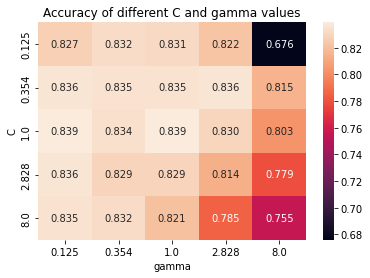

In [3]:
from matplotlib.pyplot import title
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
import seaborn as sns

# Try several values for C and gamma to demonstrate thier impact on the model accuracy
# Use 10-fold validation on each combination of params
C_range = np.logspace(-3, 3, 5, base=2)
gamma_range = np.logspace(-3, 3, 5, base=2)
classifiers = []
for C in C_range:
    for gamma in gamma_range:
        clf = SVC(C=C, gamma=gamma, kernel="rbf")
        score = np.mean(cross_val_score(clf, xTrain, yTrain, cv=10))
        op = [round(C,3), round(gamma,3), round(score,4), clf]
        classifiers.append(op)
classifiers = pd.DataFrame(data=classifiers, columns=["C", "gamma", "score", "model"])


# TRAIN CLASSIFIER USING 10 fold cross validation to determine the best parameters
param_grid = dict(gamma=gamma_range, C=C_range, kernel=["rbf"])
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scoring=["accuracy"]
grid = GridSearchCV(estimator=svmModel,
                    param_grid=param_grid,
                    scoring=scoring,
                    refit='accuracy',
                    n_jobs=-1,
                    cv=kfold,
                    verbose=0)
grid.fit(xTrain, yTrain)

print(
    "The best parameters for SVM are c=%s, gamma=%s -> score=%0.4f"
    % (round(grid.best_params_["C"],4), round(grid.best_params_["gamma"],4), grid.best_score_)
)

# Print a heatmap of the accuracy
glue = classifiers.pivot("C", "gamma", "score")
ax = plt.axes()
sns.heatmap(glue, annot=True, fmt=".3f", ax=ax)
ax.set_title("Accuracy of different C and gamma values")


The original probability of error was 0.165
The proabability of error after tuning hyperparameters is 0.1758


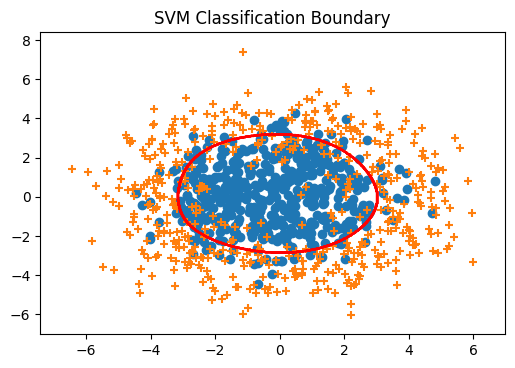

In [4]:

# Use best values for C and gamma and train the model on the full training data
bestParams = {
    "C": grid.best_params_["C"],
    "gamma": grid.best_params_["gamma"]
}
svmModel.set_params(**bestParams)
svmModel.fit(xTrain, yTrain)
print("The original probability of error was " + str(round(1-np.mean(def_accuracy), 4)))
print("The proabability of error after tuning hyperparameters is " + str(round(1-svmModel.score(xTest, yTest),4)))


# PLOT DECISION BOUNDARY
h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = xTrain[:, 0].min() - 1, xTrain[:, 0].max() + 1
y_min, y_max = xTrain[:, 1].min() - 1, xTrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].

Z = svmModel.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(dpi=100)
plt.contour(xx, yy, Z, colors='red')
plt.scatter(xTrain[yTrain == 0, 0], xTrain[yTrain == 0, 1], label="class0", marker='o' )
plt.scatter(xTrain[yTrain == 1, 0], xTrain[yTrain == 1, 1], label="class1", marker="+" )
plt.title("SVM Classification Boundary")
plt.show()

In [5]:

'''
***__Multi-Layer Perceptron (MLP) Classifier__***
'''

from sklearn.neural_network import MLPClassifier

mlpModel = MLPClassifier(random_state=1, max_iter=500)

# Print the default number of hidden layers
H = mlpModel.get_params()["hidden_layer_sizes"]

print(f"The mlpModel has the following number of perceptrons on the hidden layers: {H}")

# Use 10-fold cross validation to find the accuracy of the model using default parameters
def_accuracy = cross_val_score(mlpModel, xTrain, yTrain, cv=10)
print("The average accuracy across 10 folds is %s" % round(np.mean(def_accuracy), 4))
print("The accuracy of all folds is %s" % def_accuracy)

The mlpModel has the following number of perceptrons on the hidden layers: (100,)
The average accuracy across 10 folds is 0.829
The accuracy of all folds is [0.84 0.86 0.83 0.9  0.76 0.82 0.82 0.81 0.79 0.86]


The optimal number of perceptrons is 25 in the 1st hidden layer 
The optimal number of perceptrons is 10 in the 2nd hidden layer 
The optimal number of perceptrons yeilds an Error probability of 0.166


Text(0.5, 1.0, 'Accuracy of different perceptron counts')

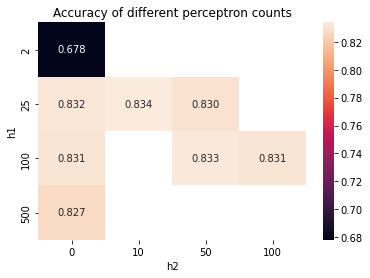

In [7]:
# test different options for number of perceptrons on hidden layers
H_range = [(2,), (25,), (100,), (500,), (25,10), (25,50), (100,50), (100,100) ]
            
clf = MLPClassifier(max_iter=300, )
classifiers = []
bestH = ((1,), 0)
for h in H_range:
    params = {"hidden_layer_sizes": h}
    clf.set_params(**params)
    score = np.mean(cross_val_score(clf, xTrain, yTrain, cv=10, n_jobs=-1))
    h1 = 0 if len(h) < 2 else h[1]
    op = [h[0], h1, round(score,4), clf]
    classifiers.append(op)
    if score > bestH[1]:
        bestH = (h, score)
classifiers = pd.DataFrame(data=classifiers, columns=["h1", "h2", "score", "model"])
print("The optimal number of perceptrons is %s in the 1st hidden layer " % bestH[0][0])
print("The optimal number of perceptrons is %s in the 2nd hidden layer " % bestH[0][1])
print("The optimal number of perceptrons yeilds an Error probability of %s" % round(1-bestH[1],4))

# Print a heatmap of the accuracy
glue = classifiers.pivot("h1", "h2", "score")
ax = plt.axes()
sns.heatmap(glue, annot=True, fmt=".3f", ax=ax)
ax.set_title("Accuracy of different perceptron counts")


The original probability of error using MLP was 0.171
The proabability of error after tuning hyperparameters is 0.1752


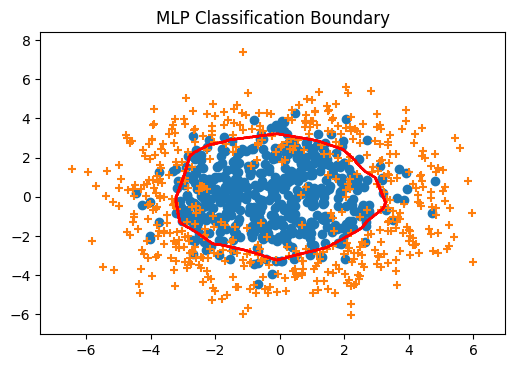

In [9]:
# Use best number of perceptrons and train the model on the full training data
bestParams = {
    "hidden_layer_sizes": bestH[0]
}
mlpModel.set_params(**bestParams)
mlpModel.fit(xTrain, yTrain)
print("The original probability of error using MLP was " + str(round(1-np.mean(def_accuracy), 4)))
print("The proabability of error after tuning hyperparameters is " + str(round(1-mlpModel.score(xTest, yTest),4)))


# PLOT DECISION BOUNDARY
h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = xTrain[:, 0].min() - 1, xTrain[:, 0].max() + 1
y_min, y_max = xTrain[:, 1].min() - 1, xTrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].

Z = mlpModel.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(dpi=100)
plt.contour(xx, yy, Z, colors='red')
plt.scatter(xTrain[yTrain == 0, 0], xTrain[yTrain == 0, 1], label="class0", marker='o' )
plt.scatter(xTrain[yTrain == 1, 0], xTrain[yTrain == 1, 1], label="class1", marker="+" )
plt.title("MLP Classification Boundary")
plt.show()

